<a href="https://colab.research.google.com/github/TolaniSilas/Computer-Vision-Research/blob/main/image_multi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import collections
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms, utils, models
from torchsummary import summary
import warnings

# Suppress all warnings.
warnings.filterwarnings("ignore")


print("All libraries and modules have been imported!")

All libraries and modules have been imported!


In [ ]:
import sklearn

# Print versions of the key libraries used in the project.
print("Library Versions:")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Library Versions:
NumPy version: 1.26.4
Pandas version: 2.1.4
Scikit-learn version: 1.2.2
PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [ ]:
!pip show torchsummary

Name: torchsummary
Version: 1.5.1
Summary: Model summary in PyTorch similar to `model.summary()` in Keras
Home-page: https://github.com/sksq96/pytorch-summary
Author: Shubham Chandel @sksq96
Author-email: shubham.zeez@gmail.com
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


In [ ]:
# Define the path to data.
path2data= "/data"

# Check if the path exists.
if not os.path.exists(path2data):
    os.mkdir(path2data)


# Define the transformation.
data_transformer = transforms.Compose([transforms.ToTensor()])

# Load the train dataset and apply the transformation on the dataset.
train_dataset = torchvision.datasets.STL10(
    root=path2data,
    split="train",
    download=True,
    transform=data_transformer
    )

Files already downloaded and verified


In [ ]:
# Retrieve the training labels.
y_train = [y for x, y in train_dataset]

# Count the number of images per category.
counter_train = collections.Counter(y_train)

print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [ ]:
# Load the STL10 test dataset with a specified data transformation.
val_test_dataset = datasets.STL10(
    path2data,
    split='test',
    download=True,
    transform=data_transformer
)

# Initialize StratifiedShuffleSplit to create a stratified split for validation and test sets.
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=0
)

# Get the indices of the entire dataset.
indices = list(range(len(val_test_dataset)))

# Extract the labels (y) for stratified splitting.
val_test_y = [y for _, y in val_test_dataset]

# Perform the stratified split
for test_index, val_index in sss.split(indices, val_test_y):
    # Print the resulting indices for debugging or verification.
    print("Test indices:", test_index)
    print("Validation indices:", val_index)
    print(f"Number of validation samples: {len(val_index)}")
    print(f"Number of test samples: {len(test_index)}")

# Create validation and test datasets using the split indices.
val_dataset = Subset(val_test_dataset, val_index)
test_dataset = Subset(val_test_dataset, test_index)

Files already downloaded and verified
Test indices: [2096 4321 2767 ... 3206 3910 2902]
Validation indices: [6332 6852 1532 ... 5766 4469 1011]
Number of validation samples: 1600
Number of test samples: 6400


In [ ]:
# Extract the labels from the validation dataset.
y_test = [y for _, y in val_dataset]
y_val = [y for _, y in val_dataset]

# Count the occurrences of each label in the test and validation datasets.
counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)

# Print the label distributions for debugging or analysis.
print("Label distribution in the test set:", counter_test)
print("Label distribution in the validation set:", counter_val)

Label distribution in the test set: Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})
Label distribution in the validation set: Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


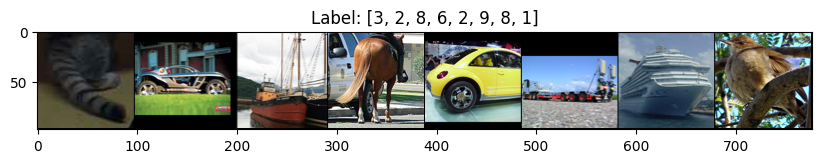

In [ ]:
def show_image(img, y=None, color=True):
    """
    Display an image using matplotlib.

    Parameters:
    img (Tensor): The image tensor to be displayed. Expected shape (C, H, W).
    y (int or str, optional): The label associated with the image. Default is None.
    color (bool, optional): Determines if the image should be displayed in color. Default is True.

    Behavior:
    - Converts the PyTorch tensor to a NumPy array and transposes it to match the shape expected by matplotlib (H, W, C).
    - Displays the image using `plt.imshow`.
    - If a label (`y`) is provided, it is displayed as the title of the image.
    """
    # Convert the PyTorch tensor to a NumPy array.
    np_img = img.numpy()

    # Transpose dimensions to match matplotlib's expected input shape (H, W, C).
    np_img_transpose = np.transpose(np_img, (1, 2, 0))

    # Display the image.
    plt.imshow(np_img_transpose)

    # Display the label as a title, if provided.
    if y is not None:
        plt.title("Label: " + str(y))

# Define the grid size for displaying multiple images.
grid_size = 8

# Select random indices from the training dataset for visualization.
random_inds = np.random.randint(0, len(train_dataset), grid_size)

# Extract the images and labels corresponding to the random indices.
x_grid = [train_dataset[i][0] for i in random_inds]
y_grid = [train_dataset[i][1] for i in random_inds]

# Create a grid of images using torchvision's utility.
x_grid = utils.make_grid(x_grid, nrow=8, padding=1)

# Set the figure size for better visualization.
plt.figure(figsize=(10, 10))

# Call the helper function to display the grid of images.
show_image(x_grid, y_grid)

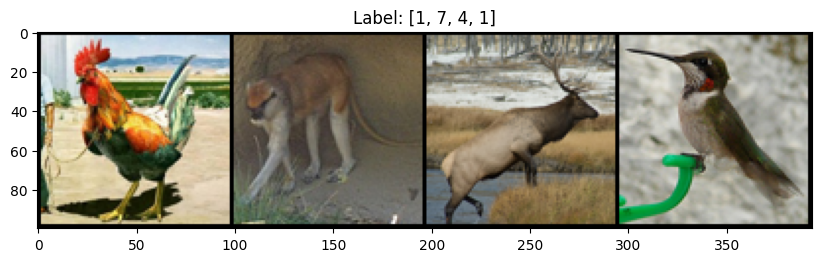

In [ ]:
# Define the grid size for displaying images.
grid_size = 4

# Select random indices from the validation dataset.
random_inds = np.random.randint(0, len(val_dataset), grid_size)

# Extract the images and labels corresponding to the random indices.
x_grid = [val_dataset[i][0] for i in random_inds]
y_grid = [val_dataset[i][1] for i in random_inds]

# Create a grid of images using torchvision's utility function.
x_grid = utils.make_grid(x_grid, nrow=4, padding=2)

# Set up the figure size for the image grid display.
plt.figure(figsize=(10, 10))

# Call the helper function to display the image grid and labels.
show_image(x_grid, y_grid)

**Calculate the mean and standard deviation of training dataset**

In [ ]:
def calculate_image_mean_std(train_dataset, gray_scale=False):
    """
    Calculate the mean and standard deviation of a dataset of images.

    Parameters:
    -----------
    train_dataset : Dataset
        A dataset containing image-label pairs, where each image is assumed
        to be a PyTorch tensor with shape (C, H, W).
    gray_scale : bool, optional
        If True, the function assumes grayscale images and calculates statistics accordingly.
        If False, it calculates statistics for RGB channels separately.

    Returns:
    --------
    tuple
        A tuple containing two elements:
        - A tuple of means for each channel (e.g., (mean_R, mean_G, mean_B) or (mean,)).
        - A tuple of standard deviations for each channel (e.g., (std_R, std_G, std_B) or (std,)).
    """

    # Calculate mean values for each channel.
    mean_RGB = [np.mean(a=x.numpy(), axis=(1, 2)) for x, y in train_dataset]

    mean_R = np.mean([m[0] for m in mean_RGB])
    mean_G = np.mean([m[1] for m in mean_RGB])
    mean_B = np.mean([m[2] for m in mean_RGB])

    # Calculate standard deviation for each channel.
    std_RGB = [np.std(a=x.numpy(), axis=(1, 2)) for x, y in train_dataset]
    std_R = np.mean([s[0] for s in std_RGB])
    std_G = np.mean([s[1] for s in std_RGB])
    std_B = np.mean([s[2] for s in std_RGB])

    # Return grayscale statistics if specified.
    if gray_scale:
        mean_gray = np.mean([np.mean(m) for m in mean_RGB])
        std_gray = np.mean([np.mean(s) for s in std_RGB])
        return (mean_gray,), (std_gray,)

    # Return RGB statistics.
    return (mean_R, mean_G, mean_B), (std_R, std_G, std_B)

# Get the mean and standard deviation of the training dataset.
mean_rgb, std_rgb = calculate_image_mean_std(train_dataset)

In [ ]:
# Define the transformation pipeline for the training dataset.
train_transformer = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [mean_rgb[0], mean_rgb[1], mean_rgb[2]],
        [std_rgb[0], std_rgb[1], std_rgb[2]]
    )
])

# Define the transformation pipeline for the validation and test datasets.
val_test_transformer = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(
        [mean_rgb[0], mean_rgb[1], mean_rgb[2]],
        [std_rgb[0], std_rgb[1], std_rgb[2]]
    )
])

# Assign training transformations (if intentional, otherwise adjust).
train_dataset.transform = train_transformer

# Overwrite with validation/test transformations.
val_test_dataset.transform = val_test_transformer

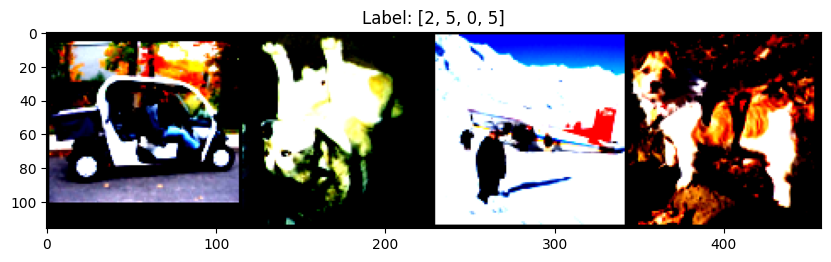

In [ ]:
np.random.seed(66)
torch.manual_seed(0)

grid_size = 4
random_inds = np.random.randint(0,len(train_dataset), grid_size)

x_grid = [train_dataset[i][0] for i in random_inds]
y_grid = [train_dataset[i][1] for i in random_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=2)


plt.figure(figsize=(10,10))
show_image(x_grid,y_grid)

In [ ]:
# Create a DataLoader for the training dataset.
train_data_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

# Create a DataLoader for the validation dataset.
val_data_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

In [ ]:
# Load the pretrained ResNet-18 model.
model_resnet18 = models.resnet18(weights='IMAGENET1K_V1')
# ResNet-18 is a popular convolutional neural network with 18 layers.

# Specify the number of classes for the new dataset.
num_classes = 10

# Get the number of input features of the original fully connected (fc) layer.
num_ftrs = model_resnet18.fc.in_features

# Replace the fully connected layer with a new one for the target number of classes. # The new layer maps the features to the desired number of output classes.
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

# Determine the device to use for computation (GPU if available, otherwise CPU).
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Print the device being used for computation.
print(f"Computation will run on: {device}")

# Move the model to the selected device
model_resnet18.to(device)

# Display the model architecture and parameter details
summary(model_resnet18, input_size=(3, 224, 224), device=device.type)

Computation will run on: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
         

0.0 1.102618932723999


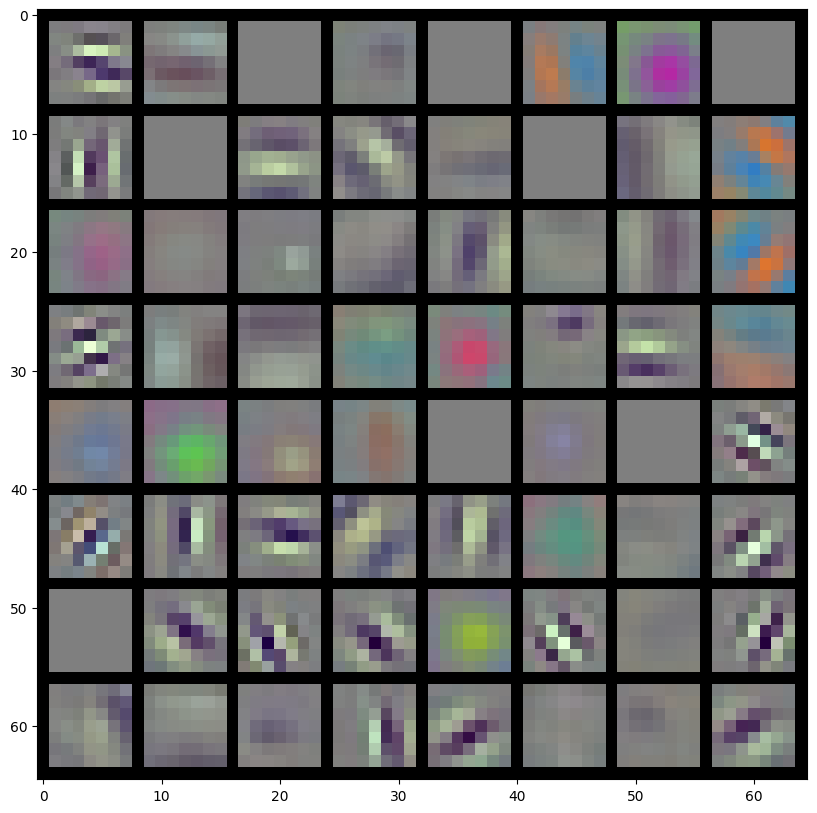

In [ ]:
# Iterate through the parameters of the ResNet-18 model.
for weight in model_resnet18.parameters():
    # Detach the weight from the computation graph and move it to the CPU for processing.
    weight = weight.detach().cpu()
    break
    # Break after the first weight (usually the first layer's weights are chosen for visualization).

# Find the minimum value in the weight tensor.
min_weight = torch.min(weight)

# Apply a transformation to the weights (here, a scaling operation based on the minimum weight value).
w1 = (-1 / (2 * min_weight)) * weight + 0.5

# Print the minimum and maximum values of the transformed weight tensor.
print(torch.min(w1).item(), torch.max(w1).item())

# Set the grid size to the length of the transformed weight tensor.
grid_size = len(w1)

# Extract individual weight tensors from the transformed weight tensor.
x_grid = [w1[i] for i in range(grid_size)]

# Create a grid from the extracted weight tensors, arranging them into rows with padding between images.
x_grid = utils.make_grid(x_grid, nrow=8, padding=1)

# Configure the figure size for displaying the weight grid.
plt.figure(figsize=(10, 10))

# Display the grid of weights as an image with labels (if applicable).
show_image(x_grid)

In [ ]:
def get_lr(opt):
    """
    Retrieve the current learning rate from the optimizer.

    Args:
        opt (torch.optim.Optimizer): The optimizer used for training.

    Returns:
        float: The current learning rate of the optimizer.
    """

    # Loop through the parameter groups in the optimizer.
    for param_group in opt.param_groups:

        # Return the learning rate from the first parameter group.
        return param_group['lr']

In [ ]:
def train_model(model, loss_func, dataloader, optimizer, sanity_check=False):
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        loss_func (function): The loss function to compute the loss.
        dataloader (torch.utils.data.DataLoader): The DataLoader for training data.
        optimizer (torch.optim.Optimizer): The optimizer to update the model's parameters.
        sanity_check (bool): If True, runs only one batch for debugging purposes.

    Returns:
        tuple: Training loss and training accuracy for the epoch.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0



    for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset the optimizer.
        optimizer.zero_grad()

        # Forward pass.
        outputs = model(x_batch)
        loss = loss_func(outputs, y_batch)

        # Backward pass
        # Compute the gradients
        loss.backward()

        # Update model parameters based on gradients.
        optimizer.step()

        # Calculate the accuracy  metrics for this batch.
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == y_batch.data).item()
        total_samples += x_batch.size(0)

        if sanity_check:
            break

    epoch_loss = running_loss / float(len(dataloader.dataset))
    epoch_acc = running_corrects / total_samples
    print(epoch_acc)

    return epoch_loss, epoch_acc



def validate_model(model, loss_func, dataloader, sanity_check=False):
    """
    Validate the model for one epoch.

    Args:
        model (torch.nn.Module): The model to validate.
        loss_func (function): The loss function to compute the loss.
        dataloader (torch.utils.data.DataLoader): The DataLoader for validation data.
        sanity_check (bool): If True, runs only one batch for debugging purposes.

    Returns:
        tuple: Validation loss and validation accuracy for the epoch.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        batch_count = 0
        for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            batch_count+= 1

            # Forward pass.
            outputs = model(x_batch)
            loss = loss_func(outputs, y_batch)

            # Calculate the accuracy  metrics for this batch.
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == y_batch.data).item()

            # Get the number of samples.
            total_samples += x_batch.size(0)

            if sanity_check:
                break

    epoch_loss = running_loss / float(len(dataloader.dataset))
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

In [ ]:
def train_val(model, params):
    """
    Train and validate the model for a specified number of epochs.

    Args:
        model (torch.nn.Module): The model to be trained and evaluated.
        params (dict): A dictionary containing training parameters:
            - 'num_epochs' (int): The number of epochs to train the model.
            - 'loss_func' (function): The loss function to compute the loss.
            - 'optimizer' (torch.optim.Optimizer): The optimizer to update the model's parameters.
            - 'train_dataloader' (torch.utils.data.DataLoader): The DataLoader for the training data.
            - 'val_dataloader' (torch.utils.data.DataLoader): The DataLoader for the validation data.
            - 'sanity_check' (bool): If True, runs only one batch for debugging purposes.
            - 'lr_scheduler' (torch.optim.lr_scheduler): The learning rate scheduler.
            - 'path2weights' (str): The path to save the best model's weights.

    Returns:
        tuple: A tuple containing:
            - The model with the best weights after training.
            - A dictionary with loss history for training and validation.
            - A dictionary with performance metrics history for training and validation.
    """

    # Extract parameters from the provided dictionary.
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    optimizer = params["optimizer"]
    train_dataloader = params["train_dataloader"]
    val_dataloader = params["val_dataloader"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]

    # Initialize dictionaries to store loss and metric history for both train and validation.
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}

    # Deep copy of the model's initial state to store the best weights.
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    # Loop through each epoch.
    for epoch in range(1, num_epochs + 1):
        # Get the current learning rate for the optimizer.
        current_lr = get_lr(optimizer)
        print(f"Epoch: {epoch}/{num_epochs}, current lr: {current_lr}")

        # Train phase: Set model to training mode and compute training loss and metric.
        train_loss, train_metric = train_model(model, loss_func, train_dataloader, optimizer, sanity_check)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # Validation phase: Set model to evaluation mode and compute validation loss and metric.
        val_loss, val_metric = validate_model(model, loss_func, val_dataloader, sanity_check)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)


        # Save the model weights if the validation loss is the best so far.
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            # Save model weights.
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        # Step the learning rate scheduler at the end of each epoch.
        lr_scheduler.step()

        # Print training and validation loss, along with the validation metric (accuracy).
        print(f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {100 * val_metric:.2f}")
        print("-" * 10)

    # Load the best model weights after training is complete.
    model.load_state_dict(best_model_weights)

    # Return the model with the best weights, and the loss and metric history for both training and validation.
    return model, loss_history, metric_history

### **Train the Model**

In [ ]:
# Define the loss function with a sum reduction for batch losses.
loss_func = nn.CrossEntropyLoss(reduction="sum")

# Set up the optimizer (Adam) for the model's parameters with a learning rate of 1e-4.
optimizer = optim.SGD(model_resnet18.parameters(), lr=1e-4)

# Configure a cosine annealing learning rate scheduler.
lr_scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=5, eta_min=1e-6)

# Ensure the directory for saving model weights exists.
os.makedirs("./models", exist_ok=True)

# Define training parameters in a dictionary for clarity and modularity.
params_train = {
    "num_epochs": 100,  # Number of training epochs.
    "optimizer": optimizer,  # Optimizer for parameter updates.
    "loss_func": loss_func,  # Loss function for training.
    "train_dataloader": train_data_loader,  # DataLoader for training data.
    "val_dataloader": val_data_loader,  # DataLoader for validation data.
    "sanity_check": False,  # Enable sanity check for debugging.
    "lr_scheduler": lr_scheduler,  # Learning rate scheduler.
    "path2weights": "./models/resnet18_pretrained.pt"  # Path to save the best model weights.
}

# Train and validate the model, capturing the final model, loss history, and metric history.
model_resnet18, loss_hist, metric_hist = train_val(model_resnet18, params_train)

Epoch: 1/100, current lr: 0.0001
0.5746
Copied best model weights!
train loss: 1.382889, val loss: 0.632029, accuracy: 81.06
----------
Epoch: 2/100, current lr: 9.05463412215599e-05
0.7734
Copied best model weights!
train loss: 0.733373, val loss: 0.448515, accuracy: 85.88
----------
Epoch: 3/100, current lr: 6.57963412215599e-05
0.8088
Copied best model weights!
train loss: 0.602329, val loss: 0.404970, accuracy: 87.38
----------
Epoch: 4/100, current lr: 3.52036587784401e-05
0.8358
Copied best model weights!
train loss: 0.513729, val loss: 0.376426, accuracy: 88.12
----------
Epoch: 5/100, current lr: 1.0453658778440105e-05
0.849
Copied best model weights!
train loss: 0.484068, val loss: 0.375029, accuracy: 88.06
----------
Epoch: 6/100, current lr: 1e-06
0.8444
Copied best model weights!
train loss: 0.489268, val loss: 0.371811, accuracy: 88.50
----------
Epoch: 7/100, current lr: 1.0453658778440102e-05
0.8404
Copied best model weights!
train loss: 0.490224, val loss: 0.367674, acc

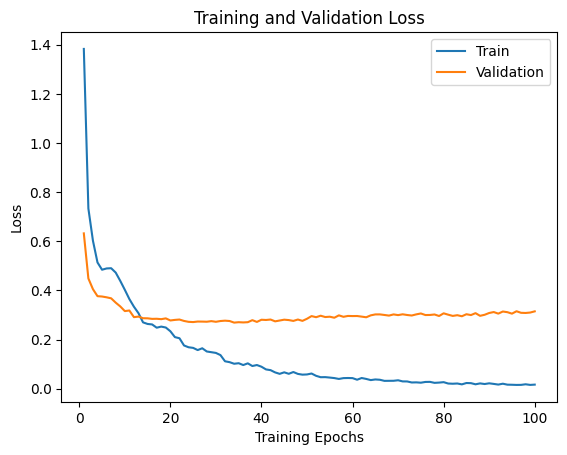

In [ ]:
# Retrieve the number of epochs from the training parameters.
num_epochs = params_train["num_epochs"]

# Plot the training and validation loss over the epochs.
plt.title("Training and Validation Loss")

# Plot training and validation loss.
plt.plot(range(1, num_epochs + 1), loss_hist["train"], label="Train")
plt.plot(range(1, num_epochs + 1), loss_hist["val"], label="Validation")

# Label the y-axis as "Loss".
plt.ylabel("Loss")

# Label the x-axis as "Training Epochs".
plt.xlabel("Training Epochs")

# Add a legend to distinguish between train and validation loss.
plt.legend()

# Display the plot.
plt.show()

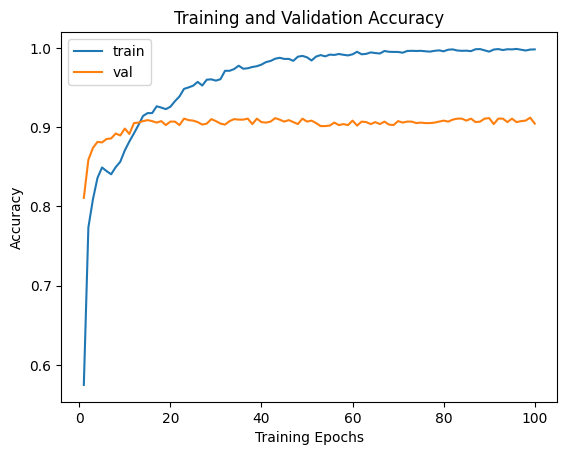

In [ ]:
# Retrieve the number of epochs from the training parameters.
num_epochs = params_train["num_epochs"]

# Plot the training and validation accuracy over the epochs.
plt.title("Training and Validation Accuracy")

# Plot training and validation accuracy.
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")

# Label the y-axis as "Loss".
plt.ylabel("Accuracy")

# Label the x-axis as "Training Epochs".
plt.xlabel("Training Epochs")

# Add a legend to distinguish between train and validation loss.
plt.legend()

# Display the plot.
plt.show()

### **Deploying the Model**

In [ ]:
# Path to save or load the pretrained ResNet-18 model weights.
model_weights_path = "./models/resnet18_pretrained.pt"

# Load the pretrained weights into the ResNet-18 model.
model_resnet18.load_state_dict(torch.load(model_weights_path))

# Set the model to evaluation mode.
model_resnet18.eval()

# Check if CUDA is available and set the device accordingly.
if torch.cuda.is_available():
    compute_device = torch.device("cuda")
    model_resnet18 = model_resnet18.to(compute_device)

# Function to deploy the model on a given dataset.
def deploy_model(model, dataset, device, num_classes=10, sanity_check=False):
    """
    Deploy the model for inference on a dataset.

    Args:
        model (torch.nn.Module): The trained model to be deployed.
        dataset (torch.utils.data.Dataset): Dataset to perform inference on.
        device (torch.device): Device to run the model on (CPU or GPU).
        num_classes (int): Number of classes in the dataset. Default is 10.
        sanity_check (bool): If True, runs inference on only the first image for debugging.

    Returns:
        tuple: Predicted probabilities (numpy array) and ground truth labels (numpy array).
    """
    # Number of samples in the dataset.
    dataset_length = len(dataset)

    # Initialize tensors to store predictions and ground truth labels.
    predictions = torch.zeros(dataset_length, num_classes)
    ground_truth_labels = np.zeros((dataset_length), dtype="uint8")

    # Move the model to the specified device.
    model = model.to(device)

    # List to store inference times for each image.
    inference_times = []

    with torch.no_grad():
        for sample_index in range(dataset_length):
            # Retrieve the input image and its label.
            input_image, true_label = dataset[sample_index]
            ground_truth_labels[sample_index] = true_label

            # Start timing the inference process.
            start_time = time.time()

            # Perform inference on the input image.
            model_output = model(input_image.unsqueeze(0).to(device))

            predictions[sample_index] = torch.softmax(model_output, dim=1)

            # Calculate and store the elapsed time.
            elapsed_time = time.time() - start_time
            inference_times.append(elapsed_time)

            # Perform a sanity check if specified.
            if sanity_check:
                break

    # Calculate the average inference time per image (in milliseconds).
    average_inference_time = np.mean(inference_times) * 1000
    print(f"Average inference time per image on {device}: {average_inference_time:.2f} ms")

    return predictions.numpy(), ground_truth_labels

**Deploy the trained model on the validation dataset.**

In [ ]:
import time
from sklearn.metrics import accuracy_score

# Deploy the pretrained ResNet-18 model on the validation dataset.
model_output, ground_truth_labels = deploy_model(model_resnet18, val_dataset, device=compute_device, sanity_check=False)

# Get the predicted class for each sample.
model_prediction = np.argmax(model_output, axis=1)

# Compute the accuracy of the model on the validation dataset.
val_accuracy = accuracy_score(model_prediction, ground_truth_labels) * 100

# Print the validation accuracy, formatted to two decimal places.
print(f"Validation accuracy: {val_accuracy:.2f}%")

Average inference time per image on cuda: 2.87 ms
Validation accuracy: 91.00%


**Deploy the trained model on the testing dataset.**

In [ ]:
# Deploy the pretrained ResNet-18 model on the testing dataset.
model_output, ground_truth_labels = deploy_model(model_resnet18, test_dataset, device=compute_device, sanity_check=False)

# Get the predicted class for each sample.
model_prediction = np.argmax(model_output, axis=1)

# Compute the accuracy of the model on the testing dataset.
testing_accuracy = accuracy_score(model_prediction, ground_truth_labels) * 100

# Print the testing accuracy, formatted to two decimal places.
print(f"Testing accuracy: {testing_accuracy:.2f}%")

Average inference time per image on cuda: 2.94 ms
Testing accuracy: 90.22%


The model's performance on the validation and testing datasets is **91.00%** and **90.22%**, respectively, signifying its robustness and reliability.